###Google Trends Prophet

In [ ]:
import datetime
import pandas as pd

try:
  import pytrends
except ModuleNotFoundError:
  !pip install pytrends
  import pytrends
from pytrends.request import TrendReq

  Created wheel for pytrends: filename=pytrends-4.7.2-cp36-none-any.whl size=14261 sha256=e512280528631174b077ae5d708e6377f0103df3136e274506bf74f1cbb5ca5f
  Stored in directory: /root/.cache/pip/wheels/64/ae/af/51d48fbbca0563036c6f80999b7ce3f097fa591fd165047baf
Successfully built pytrends


In [ ]:
try: 
  import ratelimiter
except ModuleNotFoundError:
  !pip install ratelimiter 
  import ratelimiter
from ratelimiter import RateLimiter

In [ ]:
pt = TrendReq(
    tz=0,
    timeout=(10,25), 
    retries=2,
    backoff_factor=0.1)
@RateLimiter(max_calls=1, period=10) # forces a rate limit on the function. runs once every 10sec. So we dont get kicked out of google api
def fetch_trends(keywords, start_date, end_date, sleep=0):
    """Experimentally, it seems that we can get 13 days of hourly data in a
    single request. pytrends does not log out its progress, so rather than
    depending on the library to manage rate-limiting, it is recommended to
    fetch and log 13-day batches and to manage the rate limit explicitly.
    However, the 13-day limit is not enforced by this function. If you need
    to rate-limit pytrends internally, pass in the optional sleep parameter.
    Note: The rate limit is not explicitly stated by Google. See the pytrends
    docs for more information about rate limiting.
    
    1 year of data on a single keyword is 365 / 13 = 28 requests. This keeps us
    well under the empirically documented 1400 sequential requests before
    throttling. However, this is Google ... we should be extremely conservative.
    At a 10 second/request limit, we can fetch 1 year for a keyword in about
    5 minutes.
    Returns a Pandas dataframe.
    """
    return pt.get_historical_interest(
        keywords,
        year_start=start_date.year,
        month_start=start_date.month,
        day_start=start_date.day,
        hour_start=0,
        year_end=end_date.year,
        month_end=end_date.month,
        day_end=end_date.day,
        hour_end=23,
        cat=0,
        geo='',
        gprop='',
        sleep=sleep)

In [ ]:
KEYWORDS = ['/m/02xk2n'] #Peloton Feebase ID
BATCH_SIZE = 13
START_DATE = datetime.date(2020,2,17) # Find the min from data
END_DATE = datetime.date(2020,3,17)#find the max

In [ ]:
keywords = KEYWORDS
# overshoot the end date by BATCH_SIZE to be sure we get everything
end_date = END_DATE + datetime.timedelta(days=BATCH_SIZE)
data = None
batch_start_date = START_DATE
while batch_start_date <= end_date:
    print(batch_start_date)
    batch_end_date = batch_start_date + datetime.timedelta(days=BATCH_SIZE)
    trends = fetch_trends(keywords, batch_start_date, batch_end_date)
    if data is None:
        data = trends
    else:
        data.append(trends)
    batch_start_date += datetime.timedelta(days=14)

2020-02-17
2020-03-02
2020-03-16
2020-03-30
The request failed: Google returned a response with code 500.


In [ ]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
#---  creating allmedia media prophet dataframe
prophetdata = pd.DataFrame()
prophetdata['y'] = data['/m/02xk2n']
prophetdata['ds'] = data.index

#--- pulling sponsored data out and extracting out days were there isn't 0's as changepoint
# #---- creating prohpet model
model = Prophet()
model.add_country_holidays(country_name = 'US')
model.fit(prophetdata)
future = model.make_future_dataframe(periods=60, freq='H')
future.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


,ds
392,2020-03-04 07:00:00
393,2020-03-04 08:00:00
394,2020-03-04 09:00:00
395,2020-03-04 10:00:00
396,2020-03-04 11:00:00


prophet model

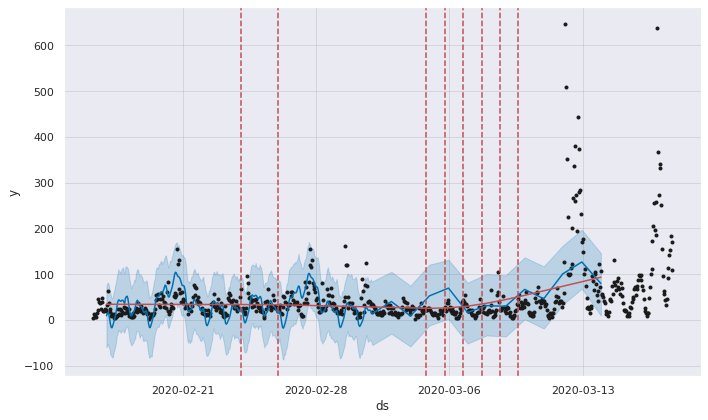

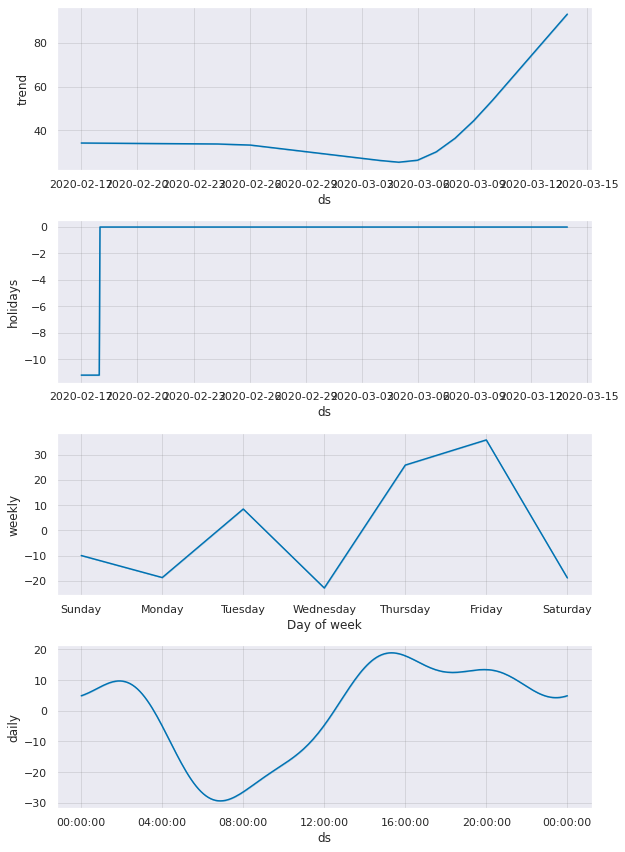

In [ ]:
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(),m,forecast)

predicting google trends interest a year from now


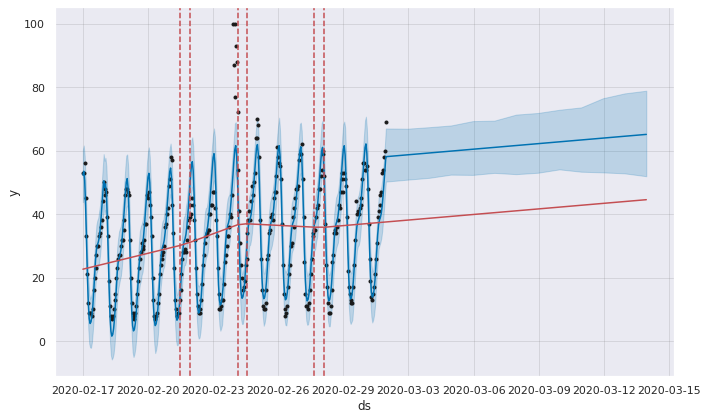

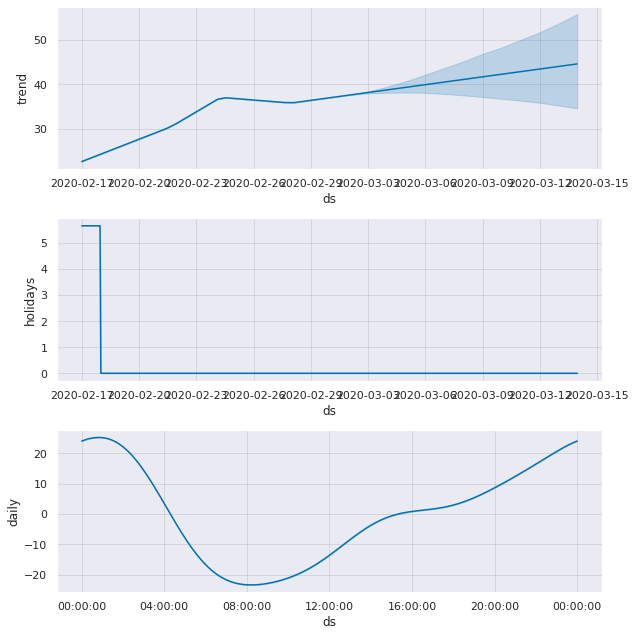

In [ ]:
future = model.make_future_dataframe(periods=12)
forecast = model.predict(future)
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

# the closer that the blue line is to the points, the better the fit of the time series
# need to subtract 2 hours from everytime bucket because we chode ET not MST 

### Google Trends ARMIA

In [ ]:
from time import sleep
import csv

import pandas as pd
from fbprophet import Prophet
import numpy as np

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
del prophetdata['ds']

In [ ]:
googleTrends = prophetdata

In [ ]:
print(googleTrends['y'].describe())

count    337.000000
mean      33.142433
std       17.390573
min        7.000000
25%       18.000000
50%       33.000000
75%       45.000000
max      100.000000
Name: y, dtype: float64


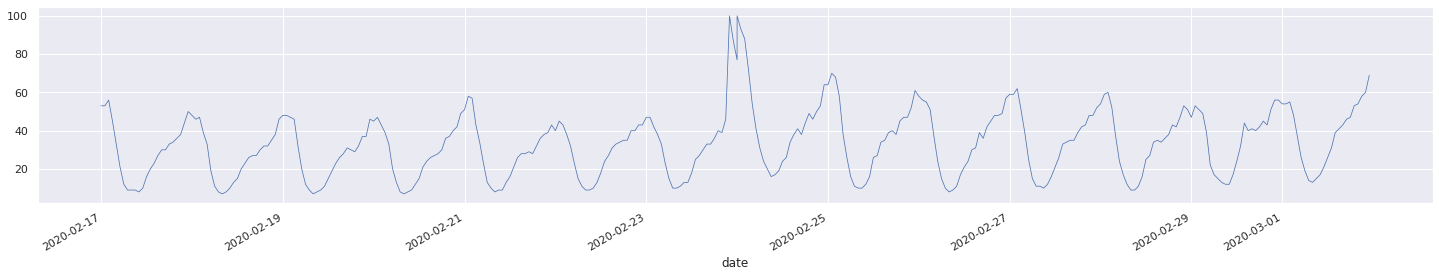

In [ ]:
pd.plotting.register_matplotlib_converters()
sns.set(rc={'figure.figsize':(25,4)})
googleTrends['y'].plot(linewidth=0.75)

In [ ]:
adf_test(googleTrends['y'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.564902
p-value                          0.100470
#Lags Used                      17.000000
Number of Observations Used    319.000000
Critical Value (1%)             -3.451017
Critical Value (5%)             -2.870643
Critical Value (10%)            -2.571620
dtype: float64


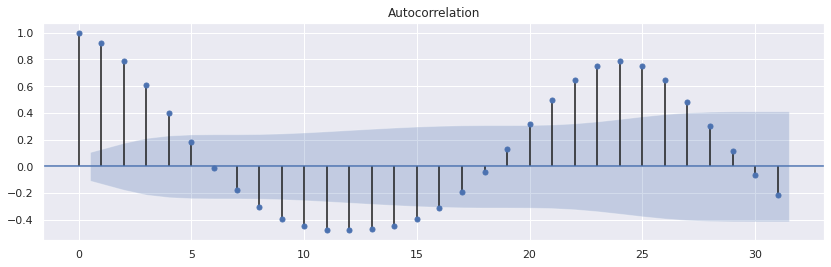

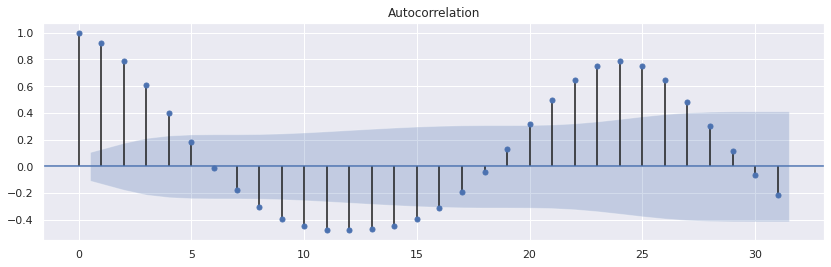

In [ ]:
plot_acf(googleTrends['y'],lags = 31)

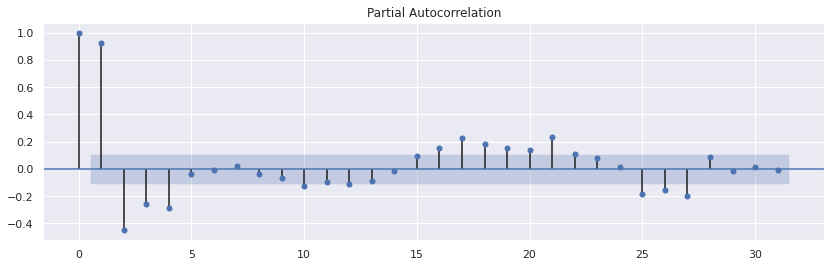

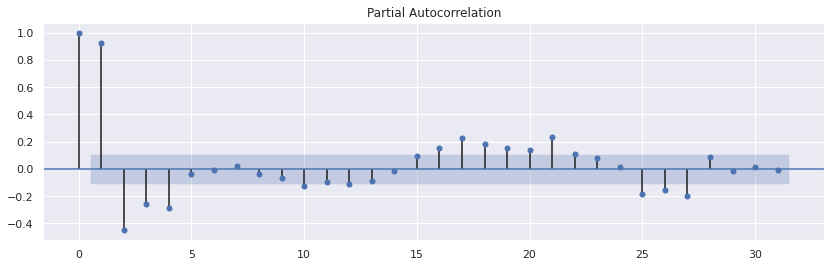

In [ ]:
plot_pacf(googleTrends['y'],lags=31)

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
model = sm.tsa.statespace.SARIMAX(googleTrends['y'],trend= 't',order=(24,1,2))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  337
Model:              SARIMAX(24, 1, 2)   Log Likelihood                -968.292
Date:                Wed, 22 Apr 2020   AIC                           1992.585
Time:                        21:47:44   BIC                           2099.464
Sample:                             0   HQIC                          2035.190
                                - 337                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0005      0.001      0.436      0.663      -0.002       0.003
ar.L1          0.1055      0.291      0.363      0.717      -0.465       0.676
ar.L2          0.0838      0.301      0.278      0.7

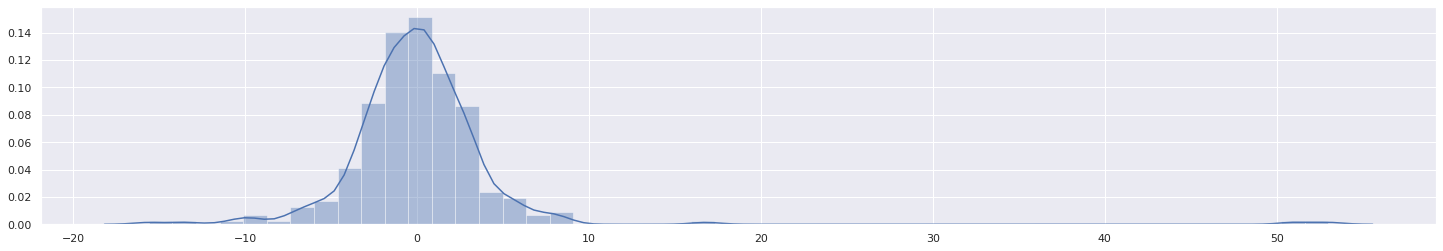

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist = True, kde = True)

###SS ARMIA



In [ ]:
from time import sleep
import csv

import pandas as pd
from fbprophet import Prophet
import numpy as np

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
count = 0
csvreader = csv.reader(open('/content/drive/My Drive/Colab Notebooks/TimeSeriesProject/peloton_-_2020_03_17_02_08_5685339.csv'))
for aline in csvreader:
  count +=1 
  print(aline)
print('%s lines of data' %count)

In [ ]:
socialStudio  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TimeSeriesProject/peloton_-_2020_03_17_02_08_5685339.csv', parse_dates=['PUBLISH_DATE'])

In [ ]:
socialStudio.tail()

,ARTICLE_ID,EXTERNAL_ID,EXTERNAL_AUTHOR_ID,HEADLINE,AUTHOR,CONTENT,ARTICLE_URL,MEDIA_PROVIDER,REGION,LANGUAGE,POST_STATUS,PUBLISH_DATE,HARVESTED_DATE,SENTIMENT,VIEW_COUNT,COMMENT_COUNT,UNIQUE_COMMENTERS,ENGAGEMENT,LIKES_AND_VOTES,INBOUND_LINKS,FORUM_THREAD_SIZE,FOLLOWING,FOLLOWERS,UPDATES,POST_TYPE
34111,1023752561409,1.228946e+18,1.290726e+08,TWEET FROM: CIOConnection,CIOCONNECTION,"The best treadmills of 2020: NordicTrack, Naut...",http://twitter.com/129072643/statuses/12289459...,TWITTER,United States,English,No,2020-02-16 07:35:27,02/16/2020 07:35:41,Positive,0,0,0,0,0,0,-1,5622,6096,22315,RETWEET
34112,1023751136671,1.228944e+18,1.117698e+08,TWEET FROM: MarketerNCust,MARKETERNCUST,"The best treadmills of 2020: NordicTrack, Naut...",http://twitter.com/111769758/statuses/12289444...,TWITTER,United States,English,No,2020-02-16 07:29:28,02/16/2020 07:29:34,Positive,0,0,0,0,0,0,-1,4826,5119,21142,RETWEET
34113,1023750897951,1.228944e+18,2.579125e+09,TWEET FROM: RickyWiIIiams,RICKYWIIIIAMS,This airplane seat-rocking fiasco has me longi...,http://twitter.com/2579125051/statuses/1228944...,TWITTER,United States,English,No,2020-02-16 07:28:27,02/16/2020 07:28:33,Negative,0,0,0,0,0,0,-1,790,447,26302,NaN
34114,1023750116801,1.228943e+18,1.097271e+18,TWEET FROM: ArceoChoya,ARCEOCHOYA,"The best treadmills of 2020: NordicTrack, Naut...",http://twitter.com/1097271067780046848/statuse...,TWITTER,Unknown,English,No,2020-02-16 07:25:07,02/16/2020 07:25:21,Positive,0,0,0,0,0,0,-1,536,474,7368,NaN
34115,1023749070538,1.228942e+18,2.579125e+09,TWEET FROM: RickyWiIIiams,RICKYWIIIIAMS,This airplane seat-rocking fiasco is making me...,http://twitter.com/2579125051/statuses/1228942...,TWITTER,United States,English,No,2020-02-16 07:20:56,02/16/2020 07:21:12,Negative,0,0,0,0,0,0,-1,790,447,26301,NaN


In [ ]:
twitter = socialStudio[socialStudio['MEDIA_PROVIDER'] == 'TWITTER']

In [ ]:
dates = pd.DataFrame() #initiating the new data structure for dates
dates['date'] = twitter['PUBLISH_DATE'].dt.round('H') # rounding down to the nearest Hour
dates.head() 

,date
0,2020-03-17 17:00:00
1,2020-03-17 17:00:00
2,2020-03-17 17:00:00
3,2020-03-17 17:00:00
4,2020-03-17 17:00:00


In [ ]:
dates['date'].value_counts()

2020-03-12 02:00:00    648
2020-03-16 22:00:00    638
2020-03-12 03:00:00    510
2020-03-12 18:00:00    443
2020-03-12 15:00:00    381
                      ... 
2020-03-06 10:00:00      3
2020-03-06 11:00:00      3
2020-02-25 06:00:00      3
2020-02-19 06:00:00      2
2020-03-04 05:00:00      2
Name: date, Length: 731, dtype: int64

In [ ]:
hour_day_pivot = pd.DataFrame(dates['date'].value_counts())  # Turning the above into a DF
hour_day_pivot.head() #indexed at hours, values are number of occurences. Not sorted however. could sort by index

,date
2020-03-12 02:00:00,648
2020-03-16 22:00:00,638
2020-03-12 03:00:00,510
2020-03-12 18:00:00,443
2020-03-12 15:00:00,381


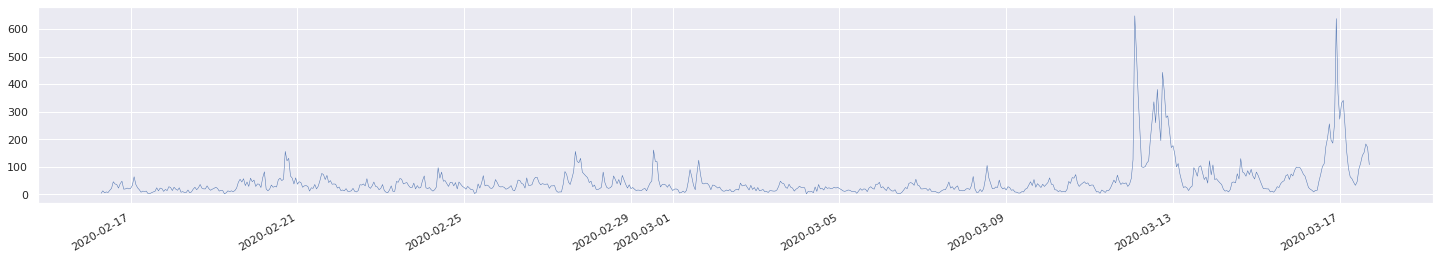

In [ ]:
sns.set(rc={'figure.figsize':(25,4)})
hour_day_pivot['date'].plot(linewidth = 0.5)

In [ ]:
hour_day_pivot.head()

,date
2020-03-12 02:00:00,648
2020-03-16 22:00:00,638
2020-03-12 03:00:00,510
2020-03-12 18:00:00,443
2020-03-12 15:00:00,381


In [ ]:
adf_test(hour_day_pivot['date'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.341402
p-value                          0.013126
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


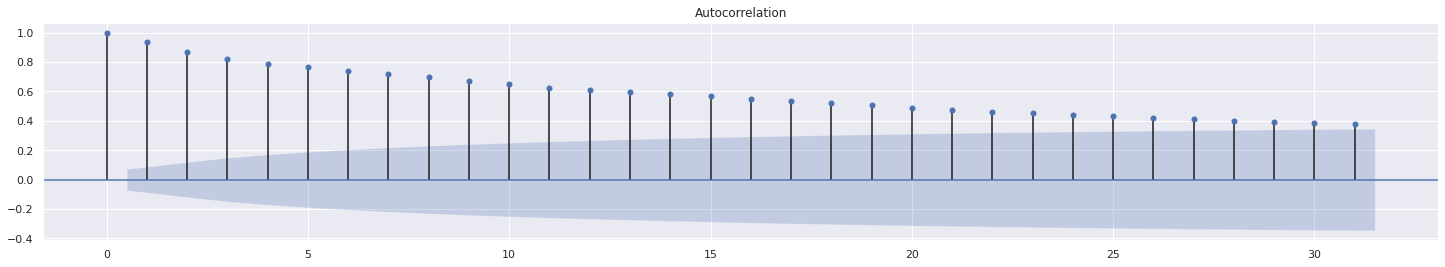

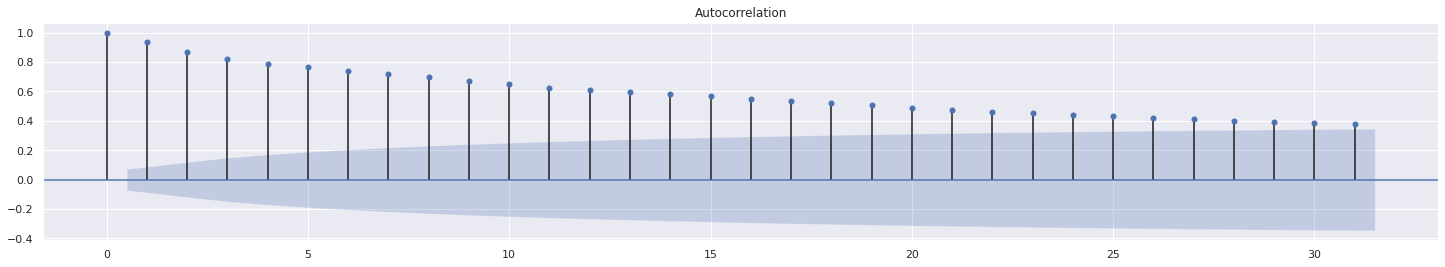

In [ ]:
plot_acf(hour_day_pivot['date'],lags = 31)

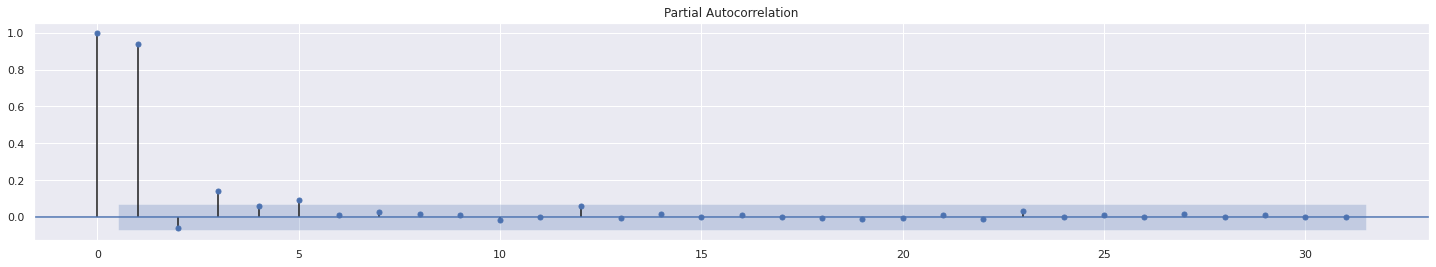

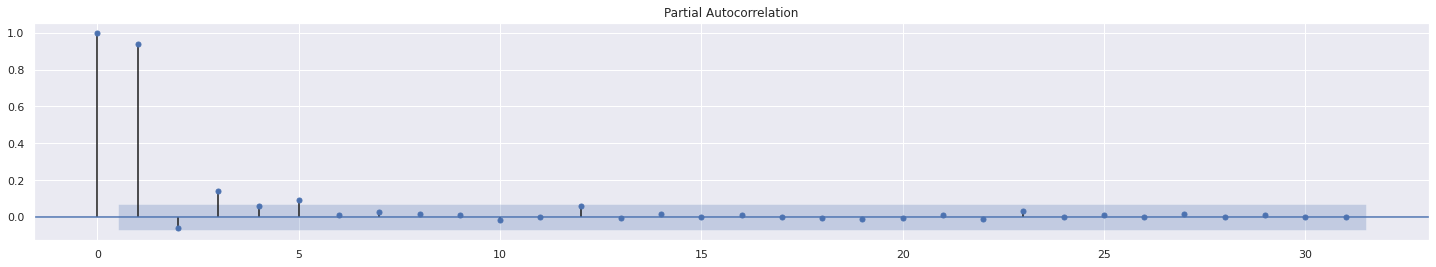

In [ ]:
plot_pacf(hour_day_pivot['date'],lags=31)

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model = ARIMA(hour_day_pivot['date'], order=(1,1,3))
model_fit = model.fit(disp=0)
summary = model_fit.summary().as_text()
for aline in summary.split(','):
  print(aline)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:                 D.date   No. Observations:                  730
Model:                 ARIMA(1
 1
 3)   Log Likelihood               -2153.839
Method:                       css-mle   S.D. of innovations              4.614
Date:                Wed
 22 Apr 2020   AIC                           4319.678
Time:                        22:39:17   BIC                           4347.236
Sample:                             1   HQIC                          4330.310
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.9631      4.551     -0.871      0.384     -12.882       4.956
ar.L1.D.date     0.9964      0.004    228.075      0.000       0.988       1.005
ma.L1.D.date    -0.4394      0.026    -16.99

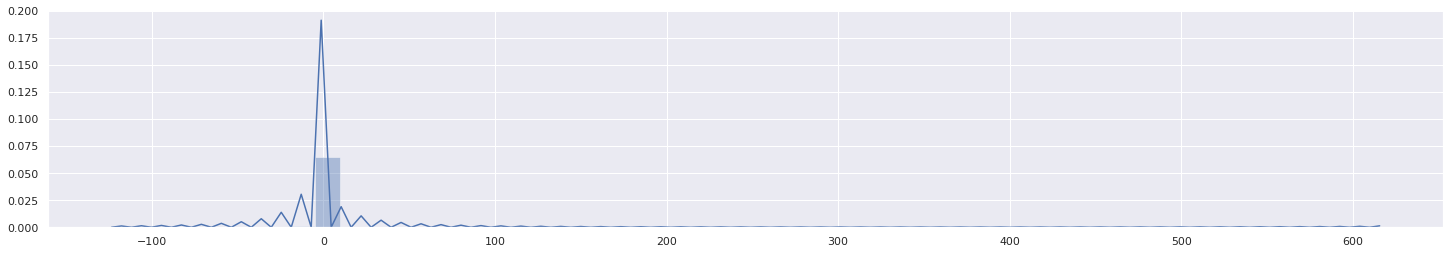

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
sns.distplot(residuals, hist = True, kde = True)

In [ ]:
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(residuals))

[1.95158346]


In [ ]:
absresiduals = abs(residuals)
print(np.mean(abs(residuals)))

0    1.194944
dtype: float64


In [ ]:
print(hour_day_pivot['date'].describe())

count    731.000000
mean      46.670315
std       64.843199
min        2.000000
25%       17.000000
50%       28.000000
75%       47.500000
max      648.000000
Name: date, dtype: float64


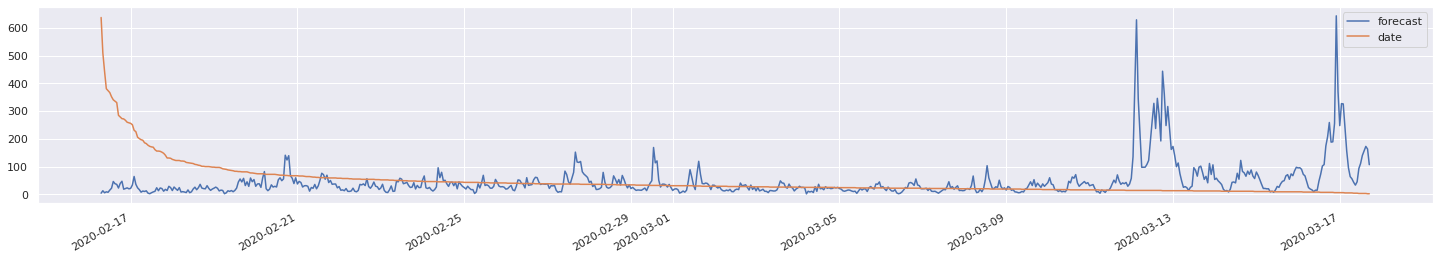

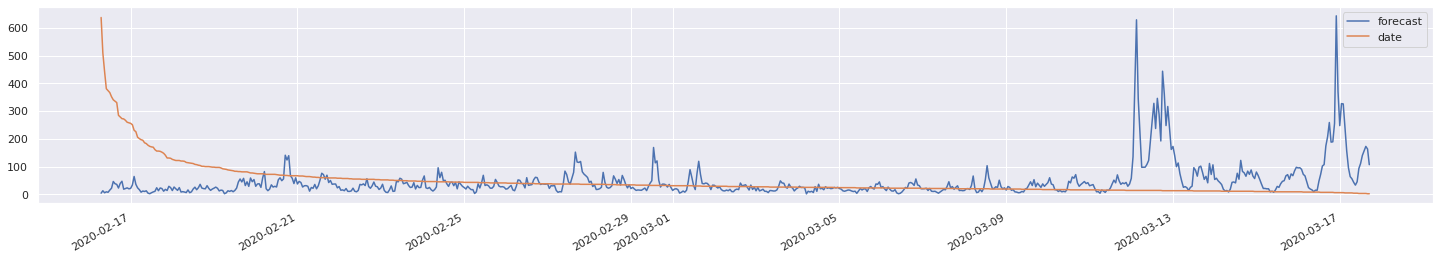

In [ ]:
pd.plotting.register_matplotlib_converters()
model_fit.plot_predict()

###SS PROPHET

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


count    731.000000
mean      46.670315
std       64.843199
min        2.000000
25%       17.000000
50%       28.000000
75%       47.500000
max      648.000000
Name: y, dtype: float64


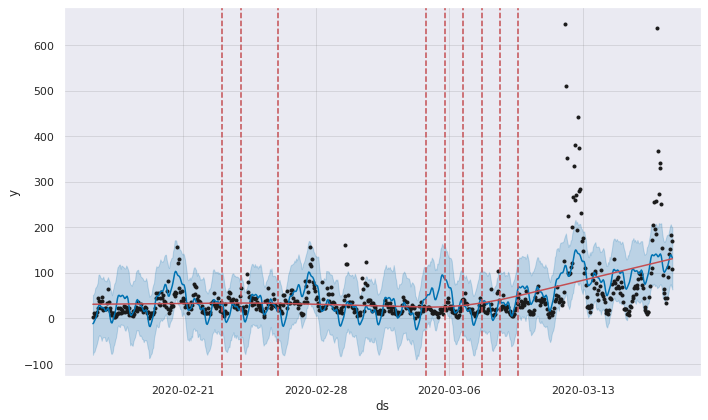

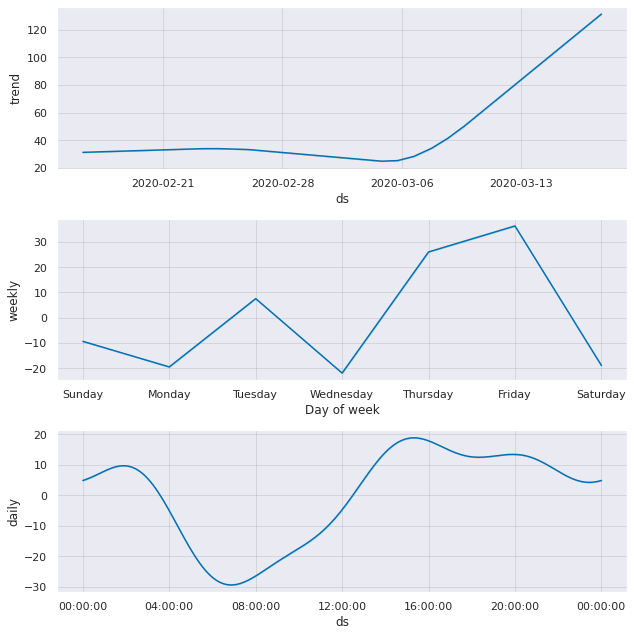

In [ ]:
#---  creating allmedia media prophet dataframe
prophetdata = pd.DataFrame(columns=['ds', 'y'])
prophetdata['y'] = hour_day_pivot['date']
prophetdata['ds'] = hour_day_pivot.index
print(prophetdata['y'].describe())
#pulling sponsored data out and extracting out days where there isnt 0s as changepoint
#creating model
model = Prophet()
model.fit(prophetdata)
future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)



# Subtract 6 hours from buckets, Twitter API is taken in GMT not MST 

In [ ]:
changepoints = ['2020-02-23','2020-03-23']
m = Prophet(changepoints=changepoints)
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(prophetdata)
future = m.make_future_dataframe(periods=60,freq='H')
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds
786,2020-03-20 01:00:00
787,2020-03-20 02:00:00
788,2020-03-20 03:00:00
789,2020-03-20 04:00:00
790,2020-03-20 05:00:00
